In [147]:
rm(list = ls());library(MASS);library(ggplot2);library(gridExtra);library(carData);library(car);library(TSA);library(jtools);library(png);library(grid);dat = read.csv("BodyFat.csv", row.names = 1);dat$WEIGHT=round(dat$WEIGHT*0.45359237,2);dat$HEIGHT=round(dat$HEIGHT*2.54,2);bodyfat48=495/1.0665-450;bodyfat96=495/1.0991-450;bodyfat76=495/1.0666-450 

## Introduction

In this project, we build a two-term nonlinear model to estimate percentage of males' body fat based on a real data set of 252 men. Our model has a good balance between simplicity, robustness, accuracy and precise. We also build a body fat calculator written by Rshiny.

## Data Cleaning 

We first take a glimpse of the raw data to see if they agree with the realistic background, whether there is any weird record, outlier or typo.
Since the unit of most of the variables is centimeter, to unify units, we convert the unit of height to centimeter. And to make it easier to calculate bmi (ADIPOSITY), also change the unit of weight to kilogram. Than the formula of bmi becomes:$BMI = \frac{WEIGHT}{{HEIGHT/100}^{2}}$

|\|MIN|1st Qu|Median|Mean|3rd Qu|Max|
|---|---|---|---|---|
|BODYFAT|0.00|12.80|19.00|18.94|24.60|45.10|
|WEIGHT|53.75|72.12|80.06|81.16|89.36|164.72|
|HEIGHT|74.93|173.35|177.80|178.18|183.52|197.49|
|AGE|22.00|35.75|43.00|44.88|54.00|81.00|

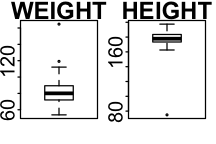

In [139]:
options(repr.plot.width=1.8,repr.plot.height=1.2,repr.plot.pointsize=2.5);par(mfrow=c(1,2));boxplot(dat$WEIGHT,main="WEIGHT");boxplot(dat$HEIGHT,main="HEIGHT")

By looking at the dataset summary and boxplots, we detect four weird records: #39 weights extremely heavy, #42 is too short, #79 much older than other men, #182 has zero bodyfat. Then we tried to use the variable values that seem to be true to predict the corresponding outlier variable for these three persons.
However, we are still not sure about whether the four outliers were wrong values or just extreme values, so we check consistency of BMI versus HEIGHT and WEIGHT, also the consistency between density and bodyfat.

#### Consistency of BMI versus HEIGHT and WEIGHT

|point|extrem value|solution|
|---|---|---|---|---|
|39|weight 164.72 kg|not change|
|42|height 74.93 cm|change to 176.35|
|79|age 81 years old|not change|

We change the height of #42 but retain #79 and the weight of #39 because it seems that the 79th is a normal thin old man, the 39th is a very heavy man which follows the bmi equation. We'd better keep more information.

In [140]:
dat$HEIGHT[42]=round(sqrt(92.99/29.9)*100,2)

#### Consistency between DENSITY and BODYFAT

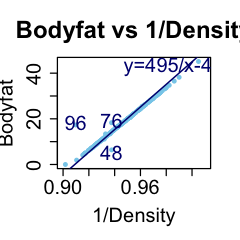

In [141]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.pointsize=7);par(mfrow=c(1,1));plot(dat$BODYFAT~I(dat$DENSITY^(-1)),xlim=c(0.90,1.01),ylab="Bodyfat",xlab="1/Density",col="skyblue",pch=19,cex=0.7,main="Bodyfat vs 1/Density");x=seq(0.9,1.01,0.01);lines(x,y=x*495-450,col="navyblue",lwd=1.2);text(0.99,43,"y=495/x-450",col="navyblue",cex=1);text(1/1.0991,18.3,"96",col="navyblue",cex=1);text(1/1.0665,5.4,"48",col="navyblue",cex=1);text(1/1.0666,19.3,"76",col="navyblue",cex=1)

We delete #182 variable because it can't be imputed by density, the value of 495/1.1089 - 450 is less than zero.
Also, noticing there are three data points whose bodyfat conflict with density use the siri's formula. 
Since we are not sure of the bodyfat and density which one is wrong, we search for a bodyfat calculator as reference to re-calculate these three bodyfat usig Weight and Waist Circumference(Abdomen) two variables.

|point|bodyfat/density wrong|solution|
|---|---|---|---|---|
|48|bodyfat wrong|bodyfat change to 14.14|
|96|density wrong|keep bodyfat|
|76|density wrong|keep bodyfat|
|182|bodyfat wrong|delete|

After checking the bodyfat calculated by siri's formula and by calculator, we got the conclusion that only point 48 has wrong bodyfat and we use siri's formula to impute it.

In [142]:
dat=dat[-182,];dat$BODYFAT[48]=bodyfat48;dat=dat[,-2] #delete density

## Variable Selection

According to the forward variables selection based on AIC above, considering the simplicity, the best models with different number of variables, 1 to 4, are as below:

In [143]:
m1<-lm(BODYFAT~ABDOMEN,data=dat);m2<-lm(BODYFAT~ABDOMEN+WEIGHT,data=dat);m3<-lm(BODYFAT~ABDOMEN+WEIGHT+WRIST,data=dat);m4<-lm(BODYFAT~ABDOMEN+WEIGHT+WRIST+FOREARM,data=dat)

|model name|model|
|---|---|
|m1|BODYFAT~ABDOMEN|
|m2|BODYFAT~ABDOMEN+WEIGHT|
|m3|BODYFAT~ABDOMEN+WEIGHT+WRIST|
|m4|BODYFAT~ABDOMEN+WEIGHT+WRIST+FOREARM|

The variables selected are mainly Abdomen, Weight and Wrist and we want to look into their relationships and give a intuitive analysis based on data visualization.

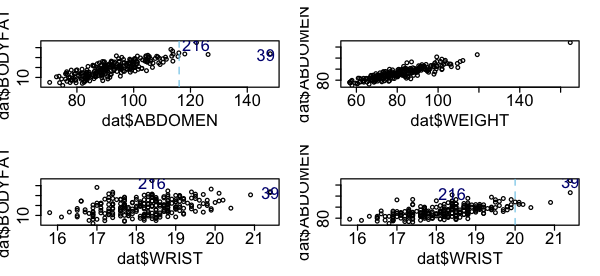

In [144]:
options(repr.plot.width=5,repr.plot.height=2.3,repr.plot.pointsize=6);par(mfrow=c(2,2));plot(dat$BODYFAT~dat$ABDOMEN);abline(v=116,col="skyblue",lty="dashed");text(122,43.5,"216",col="navyblue",cex=1);text(146.5,32.5,"39",col="navyblue",cex=1);plot(dat$ABDOMEN~dat$WEIGHT);plot(dat$BODYFAT~dat$WRIST);text(18.4,43.5,"216",col="navyblue",cex=1);text(21.4,32.5,"39",col="navyblue",cex=1);plot(dat$ABDOMEN~dat$WRIST);abline(v=20,col="skyblue",lty="dashed");text(18.4,124,"216",col="navyblue",cex=1);text(21.4,146,"39",col="navyblue",cex=1)

There exists an obvious linear relationship between Abdomen and Weight, so the second model (m2) is unreliable because of the multicollinearity. The vif test and high correlation (0.89) between the two variables also support this statement.
The fourth model (m4) has the same problem of multicollinearity.

|model|ABDOMEN|WEIGHT|WRIST|FOREARM|
|---|---|---|---|---|
|m2 vif|4.73|4.73|  |  |
|m4 vif|4.86|7.04|2.27|1.79|


Because our goal is to find out a simple and accurate model, we first put Model 4 aside and try to make some improvements on Model 2 and 3.

## Model Modification and Improvement

#### Ridge regression
In order to eliminate multicollinearity of m2 model,we use ridge regression and calculate MSE.

#### Nonlinear model with interation term

Althouth there's strong linearity between Abdomen and Bodyfat, Bodyfat is influenced by other factors with higher abdomen level and it seems to be a nonlinear relationship on the right side of the vertical line.
Wrist circumsference has no big influence on lower weight males, but extremely large wrist circumsference will lead to large abdomen circumsference and heavy weight. We can see the Abdomen increases rapidly when Wrist is larger than 20.
To further explore their mutual influences, we turn to use interaction plots.

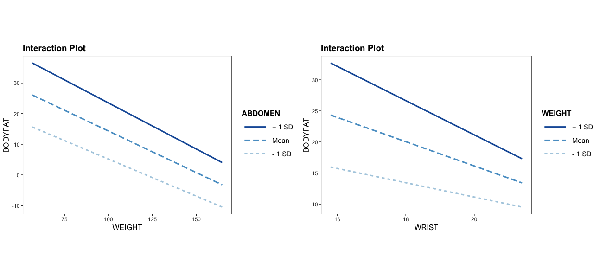

In [145]:
comb2pngs <- function(imgs, bottom_text = NULL){
    img1 <-  grid::rasterGrob(as.raster(readPNG(imgs[1])),interpolate = FALSE)
    img2 <-  grid::rasterGrob(as.raster(readPNG(imgs[2])),interpolate = FALSE)
  grid.arrange(img1, img2, ncol = 2, bottom = bottom_text)}
comb2pngs(c("picture6.png", "picture7.png"))

Out of our expectation, at same Abdomen level, heavier males will have lower bodyfat. Meanwhile, with same weight level, males with larger wrist circumsference will have lower bodyfat.
Therefore, we decide to include the WEIGHT and WRIST interaction term into our model to interprete their complicated relationships. And it turns out to be a really good model.

## Model Comparison

| Model | Adj.R-squared | MSE |
|---|---|---|
|m2_ridge| 0.7127 | 16.69 |
|m3| 0.7185 | 16.16 |
|m5| 0.7258 | 15.80|

m2_ridge is improved from m2 and m5 is improved from m3. Table below examines the accuracy of these three models by adjusted $R^{2}$ and MSE. As is shown, model 5 (m5) is much better according to both criteria. Therefore, we choose model 5 as our final model.

$$ Bodyfat(\%) = -45.3249 + 0.9092\times Abdomen(cm) -0.0133\times Weight(kg)\times Wrist(cm)$$

Below is the coefficients of the model 5 and all of the coefficients are significant.

|/|Estimate|Std.Error|t value|P value|
|---|---|---|---|---|
|Intercept|-45.3249|2.573|-17.62|<2e-16|
|ABDOMEN| 0.9092| 0.047| 19.42| <2e-16|
|WEIGHT:WRIST|-0.0133|0.002|-8.22|1.14e-14|

## Model Diagnostic

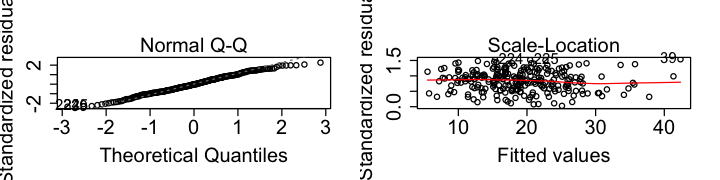

In [146]:
m5<-lm(BODYFAT~ABDOMEN+WEIGHT:WRIST,data=dat);options(repr.plot.width=6,repr.plot.height=1.5,repr.plot.pointsize=7);par(mfrow=c(1,2));plot(m5,which=c(2,3))

#### Normality Assumption

We do Shapiro-Wilk normality test to check normality, and got p-value=0.1039

$H_{0}$: the residual follows normal distribution. 

P-value is larger than $0.05$, retain $H_{0}$. So the residual follows normal distribution.

#### Homoscedasticity Assumption

We do Non-constant Variance Score Test to check Homoscedasticity, and got p value=0.989.

$H_{0}$: homoscedasticity vs $H_{1}$:variance residuals vary with the level of fitted values

P-value is larger than $0.05$, retain $H_{0}$. So the residual follows homoscedasticity  assumption.

#### Robustness

|term|Value|Std.Error|t value|
|---|---|---|---|
|Intercept|-46.652|2.761|-16.894|
|ABDOMEN| 0.922| 0.051| 18.255|
|WEIGHT:WRIST|-0.013|0.002|-7.558|

The coefficients of the robust model5 are very close to those of the previous model5, which means model5 is robust to some extent.

## Rules of thumb

$$ Bodyfat(\%) = -45 + 0.91\times Abdomen(cm) -0.013\times Weight(kg)\times Wrist(cm)$$

#### Explain the practical meaning of this model:

For a 75 kg man whose abdomen is 85 cm, wrist is 18 cm, his predicted bodyfat is around 14.97%. There is a 95% probability that his bodyfat is between 14.35% and 15.59%. This model is a simpler one to calculate bodyfat, it predicts this person has 14.8% bodyfat.

## Strengths and weakness

Our model is the most accurate one, compared with other models including same variables or less variables, and it even has a smaller adjusted R-squared than the four-variable one. So we think it is a good tradeoff between simplicity(less variables and less terms) and accuracy(R-squared and MSE).

Our model can be interpreted in a practical way. It is reasonable that heavier men’s body fat rapidly grows with extremely thicker wrist, while normal weight males has  larger body fat  percentage with relatively thinner wrist.

Our model solves the problem of multicollinearity between independent variables that some other models have.

Although the model is not complicated, which only has two terms, its coefficients are hard for people to memorize.

#### Contribution and reference   


[1] Bodyfat calculator https://www.active.com/fitness/calculators/bodyfat 

[2] M-estimator https://en.wikipedia.org/wiki/M-estimator
